# 

- **Questions**: [Here](../data/homework_2/HW.pdf)
- **Answer Set** : NO. 02
- **Full Name** : Fatemeh Karimi Barikarasfi
- **Student Code** : 610301060

In this homework, Hidden Markov Model and Viterbi algorithm are used for Part of Speech Tagging problem.

[Dataset](../data/homework_2/dataset)

## Importing Needed Libraries

In [1]:
import warnings
import numpy as np
import pandas as pd
import sklearn as sk
import matplotlib.pyplot as plt

import nltk as nltk
import nltk.corpus.reader.conll as nltkconll

warnings.filterwarnings("ignore", category=UserWarning)

## Loading dataset

For loading dataset nltk.corpus.reader.conll is used.

In [2]:
train_reader = nltkconll.ConllCorpusReader(".", ["Train.txt"], ("words", "pos"))
test_reader = nltkconll.ConllCorpusReader(".", ["Test.txt"], ("words",))
val_reader = nltkconll.ConllCorpusReader(".", ["Val.txt"], ("words", "pos"))

Sentences of train, validation, and test data:

In [3]:
train_sents = list(train_reader.sents())
test_sents = list(test_reader.sents())
val_sents = list(val_reader.sents())

For instance, third sentence of train dataset is shown below:

In [4]:
train_sents[2]

['صورتهاي',
 'گسترشيافته',
 'و',
 'نيز',
 'الگوي',
 'برجستگي',
 'هر',
 'كدام',
 'از',
 'انواع',
 'فعلها',
 'را',
 'بدون',
 'در',
 'نظر',
 'گرفتن',
 'ويژگيهاي',
 'زيرمقوله',
 'آنها',
 'در',
 'بالا',
 'ديديم',
 '.']

(Word, Tag) pair:

In [5]:
train_word_tag = list(train_reader.tagged_sents())
val_word_tag = list(val_reader.tagged_sents())

In [6]:
train_word_tag[2]

[('صورتهاي', 'N'),
 ('گسترشيافته', 'ADJ'),
 ('و', 'CON'),
 ('نيز', 'CON'),
 ('الگوي', 'N'),
 ('برجستگي', 'N'),
 ('هر', 'QUA'),
 ('كدام', 'N'),
 ('از', 'P'),
 ('انواع', 'N'),
 ('فعلها', 'N'),
 ('را', 'P'),
 ('بدون', 'P'),
 ('در', 'P'),
 ('نظر', 'N'),
 ('گرفتن', 'N'),
 ('ويژگيهاي', 'N'),
 ('زيرمقوله', 'ADJ'),
 ('آنها', 'PRO'),
 ('در', 'P'),
 ('بالا', 'N'),
 ('ديديم', 'V'),
 ('.', 'DELM')]

Words and tags are seperated:

In [7]:
train_words = [word for sent in train_reader.tagged_sents() for (word, _) in sent]
train_tags = [tag for sent in train_reader.tagged_sents() for (_, tag) in sent]

val_words = [word for sent in val_reader.tagged_sents() for (word, _) in sent]
val_tags = [tag for sent in val_reader.tagged_sents() for (_, tag) in sent]

test_words = test_reader.words()

Number of unique tags in train dataset:

In [10]:
len(dict(nltk.FreqDist(train_tags)).keys())

23

Number of unique words in train dataset:

In [11]:
len(nltk.FreqDist(train_words))

18949

Number of unique words in test dataset:

In [12]:
len(nltk.FreqDist(test_words))

10594

Number of unique words in validation dataset:

In [13]:
len(nltk.FreqDist(val_words))

16235

Words that are not in train dataset but accur in test and validation dataset:

In [ ]:
unique_train_words = list(nltk.FreqDist(train_words).keys())

oov_train_words = [w for w in list(nltk.FreqDist(train_words).keys()) if w not in unique_train_words]
oov_test_words = [w for w in list(nltk.FreqDist(test_words).keys()) if w not in unique_train_words]
oov_val_words = [w for w in list(nltk.FreqDist(val_words).keys()) if w not in unique_train_words]

Percentage of unique words that are in test dataset, but not in train dataset:

In [16]:
len(oov_test_words)
len(oov_test_words) / len(list(nltk.FreqDist(test_words).keys()))

0.4692278648291486

Percentage of unique words that are in validation dataset, but not in train dataset:

In [18]:
len(oov_val_words)
len(oov_val_words) / len(list(nltk.FreqDist(val_words).keys()))

0.5498614105327995

## HMM

In the following, some functions are written which are used in HMM and POSTagger classes.

In HMM class, Add-k smoothing technique is used for calculating probability.

In [19]:
words_frequency = nltk.FreqDist(train_reader.words())

def words_sents(reader):
    yield ["OOV"]
    for sent in reader.sents():
        yield [
            word if words_frequency.get(word) != None else "OOV" 
            for word in sent
        ]

def tags_sents(reader):
    yield ["N"]
    for sent in reader.tagged_sents():
        yield [tag for (_, tag) in sent]

In [20]:
def label2id(labels):
    label_encoder = dict()
    i = 0
    for item in labels:
        if item not in label_encoder.keys():
            label_encoder[item] = i
            i = i + 1     
    return label_encoder

def encoder(text, labels):
    encoder = []
    for w in text:
        encoder.append(labels[w])
    return encoder    
    
def id2label(code, labels):
    for k, v in labels.items():
        if v == code:
            return k

def decoder(text, labels):
    decoder = []
    for w in text:
        decoder.append(id2label(w, labels))
    return decoder

In [21]:
def ngram(tokens, n):
    return [tuple(tokens[i: i+n]) for i in range(len(tokens) - n + 1)]

In [22]:
def accuracy(pred_tags, true_tags):
    return sum([
        1 if pred_tags[i] == true_tags[i] else 0
        for i in range(len(pred_tags))
    ]) / len(pred_tags)

In [23]:
def add_k(c, k):
    p = np.zeros(c.shape, dtype='float')
    p = c + k
    for i in range(len(p)):
        p[i] = p[i] / sum(p[i]) 
    
    return p

In [24]:
class HMM:    
    def calcPi(self, X, Y, k):
        Pi = np.zeros(self.states)
        for seq in Y:
            Pi[seq[0]] = Pi[seq[0]] + 1
        
        return Pi
    
    def calcA(self, X, Y, k):
        bigrams = [bigram for seq in Y for bigram in ngram(seq, 2)]
        A = np.zeros((self.states, self.states))
        for bigram in bigrams:
            A[bigram] = A[bigram] + 1
        
        return add_k(A, k)

    def calcB(self, X, Y, k):
        flatX = [x for seq in X for x in seq]
        flatY = [y for seq in Y for y in seq]

        B = np.zeros((len(list(nltk.FreqDist(flatY).keys())), len(list(nltk.FreqDist(flatX).keys()))))
        for i in range(len(flatX)):
            B[flatY[i]][flatX[i]] = B[flatY[i]][flatX[i]] + 1
        
        return add_k(B, k)

    def calcDeltaPsi(self, x):
        Delta = np.zeros((self.states, len(x)))
        Psi = np.zeros((self.states, len(x)))
        for i in range(self.states):
            Delta[i][0] = np.log(self.Pi[i]) + np.log(self.B[i][x[0]])
        
        for t in range(1, len(x)):
            for j in range(self.states):
                Delta[j][t] = max([Delta[i][t-1] + np.log(self.A[i][j]) for i in range(self.states)])
                Psi[j][t] = np.argmax([Delta[i][t-1] + np.log(self.A[i][j]) for i in range(self.states)])
                Delta[j][t] = Delta[j][t] + np.log(self.B[j][x[t]])
        return Delta, Psi

    def fit(self, X, Y, k):
        flatY = [y for seq in Y for y in seq]
        self.states = len(set(flatY))

        self.Pi = self.calcPi(X, Y, k)
        self.A = self.calcA(X, Y, k)
        self.B = self.calcB(X, Y, k)

    def predict(self, x):
        Delta, Psi = self.calcDeltaPsi(x)

        T = len(x)
        path = np.zeros(T, dtype=int)
        path[T-1] = int(np.argmax(Delta[:, T-1]))
        t = T - 2
        while (t > 0):
            path[t] = Psi[int(path[t+1])][t+1]
            t = t - 1
        
        return path

In [25]:
class POSTagger(HMM):

    def fit(self, reader, k):
        flatWords = [word for seq in words_sents(reader) for word in seq]
        flatTags = [tag for seq in tags_sents(reader) for tag in seq]
        
        self.words_label2id = label2id(list(nltk.FreqDist(flatWords).keys()))
        self.tags_label2id = label2id(list(nltk.FreqDist(flatTags).keys()))
        
        super(POSTagger, self).fit(
            [encoder(seq, self.words_label2id) for seq in words_sents(reader)], 
            [encoder(seq, self.tags_label2id) for seq in tags_sents(reader)], k
        )

    def predict(self, reader):
        words = words_sents(reader)
        
        return [
            decoder(super(POSTagger, self).predict(encoder(seq, self.words_label2id)), self.tags_label2id)
            for seq in words
        ]

## Models

In this section, several HMM models have been implemented for different values of k.

In [26]:
val_true_tags = [tag for seq in tags_sents(val_reader) for tag in seq]
train_true_tags = [tag for seq in tags_sents(train_reader) for tag in seq]

### k = 1

In [42]:
tagger_1 = POSTagger()
tagger_1.fit(train_reader, 1)

pred_tags = [tag for seq in tagger_1.predict(val_reader) for tag in seq]
val_acc_1 = accuracy(pred_tags, val_true_tags) * 100

pred_tags = [tag for seq in tagger_1.predict(train_reader) for tag in seq]
train_acc_1 = accuracy(pred_tags, train_true_tags) * 100

print('Train Accuracy = ', train_acc_1, 'and, Validation Accuracy = ', val_acc_1)

Train Accuracy =  93.30472103004291 and, Validation Accuracy =  89.8624702604988


### k = 0.1

In [43]:
tagger_2 = POSTagger()
tagger_2.fit(train_reader, 0.1)

pred_tags = [tag for seq in tagger_2.predict(val_reader) for tag in seq]
val_acc_2 = accuracy(pred_tags, val_true_tags) * 100

pred_tags = [tag for seq in tagger_2.predict(train_reader) for tag in seq]
train_acc_2 = accuracy(pred_tags, train_true_tags) * 100

print('Train Accuracy = ', train_acc_2, 'and, Validation Accuracy = ', val_acc_2)

Train Accuracy =  95.52724263361496 and, Validation Accuracy =  93.60648801903328


### k = 0.01

In [44]:
tagger_3 = POSTagger()
tagger_3.fit(train_reader, 0.01)

pred_tags = [tag for seq in tagger_3.predict(val_reader) for tag in seq]
val_acc_3 = accuracy(pred_tags, val_true_tags) * 100

pred_tags = [tag for seq in tagger_3.predict(train_reader) for tag in seq]
train_acc_3 = accuracy(pred_tags, train_true_tags) * 100

print('Train Accuracy = ', train_acc_3, 'and, Validation Accuracy = ', val_acc_3)

Train Accuracy =  95.8536538424527 and, Validation Accuracy =  94.65925262504327


### k = 0.001

In [45]:
tagger_4 = POSTagger()
tagger_4.fit(train_reader, 0.001)

pred_tags = [tag for seq in tagger_4.predict(val_reader) for tag in seq]
val_acc_4 = accuracy(pred_tags, val_true_tags) * 100

pred_tags = [tag for seq in tagger_4.predict(train_reader) for tag in seq]
train_acc_4 = accuracy(pred_tags, train_true_tags) * 100

print('Train Accuracy = ', train_acc_4, 'and, Validation Accuracy = ', val_acc_4)

Train Accuracy =  95.86443157104641 and, Validation Accuracy =  94.68068154969588


### k = 0.0001

In [46]:
tagger_5 = POSTagger()
tagger_5.fit(train_reader, 0.0001)

pred_tags = [tag for seq in tagger_5.predict(val_reader) for tag in seq]
val_acc_5 = accuracy(pred_tags, val_true_tags) * 100

pred_tags = [tag for seq in tagger_5.predict(train_reader) for tag in seq]
train_acc_5 = accuracy(pred_tags, train_true_tags) * 100

print('Train Accuracy = ', train_acc_5, 'and, Validation Accuracy = ', val_acc_5)

Train Accuracy =  95.86481648992475 and, Validation Accuracy =  94.67958263048291


### k = 0.00001

In [47]:
tagger_6 = POSTagger()
tagger_6.fit(train_reader, 0.00001)

pred_tags = [tag for seq in tagger_6.predict(val_reader) for tag in seq]
val_acc_6 = accuracy(pred_tags, val_true_tags) * 100

pred_tags = [tag for seq in tagger_6.predict(train_reader) for tag in seq]
train_acc_6 = accuracy(pred_tags, train_true_tags) * 100

print('Train Accuracy = ', train_acc_6, 'and, Validation Accuracy = ', val_acc_6)

Train Accuracy =  95.86520140880309 and, Validation Accuracy =  94.67903317087645


### k = 0.00000001

In [48]:
tagger_7 = POSTagger()
tagger_7.fit(train_reader, 0.00000001)

pred_tags = [tag for seq in tagger_7.predict(val_reader) for tag in seq]
val_acc_7 = accuracy(pred_tags, val_true_tags) * 100

pred_tags = [tag for seq in tagger_7.predict(train_reader) for tag in seq]
train_acc_7 = accuracy(pred_tags, train_true_tags) * 100

print('Train Accuracy = ', train_acc_7, 'and, Validation Accuracy = ', val_acc_7)

Train Accuracy =  95.86520140880309 and, Validation Accuracy =  94.67958263048291


Plot the Validation and Train Accuray of each models:

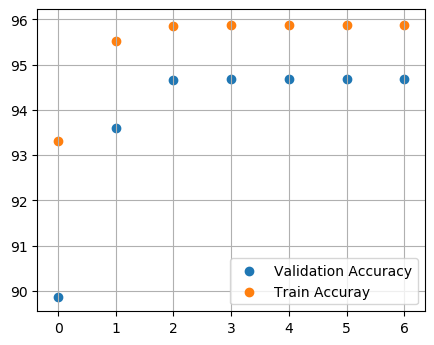

In [53]:
val_acc = [val_acc_1, val_acc_2, val_acc_3, val_acc_4,
          val_acc_5, val_acc_6, val_acc_7]

train_acc = [train_acc_1, train_acc_2, train_acc_3, train_acc_4,
            train_acc_5, train_acc_6, train_acc_7]

plt.figure(figsize = (5, 4), dpi = 100)

plt.scatter(range(0, 7), val_acc, label = 'Validation Accuracy')
plt.scatter(range(0, 7), train_acc, label = 'Train Accuray')
plt.legend()
plt.grid()

plt.show()

Model with k = 0.01 is chosen as the best model, and predict the test POS by it and save them:

In [65]:
test_labels = [tag for seq in tagger_3.predict(test_reader) for tag in seq]
f = open('./y_test.txt', 'w')
f.write('\n'.join(test_labels))

217241